# オートエンコーダ（AE）

## モジュールインポート・クラス定義

### モジュールのインポート

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

### データセットのダウンロード

In [2]:
# transform = transforms.Compose([transforms.ToTensor()])
# traindata = torchvision.datasets.MNIST(root='./data', train=True,download=True,transform=transform)
# trainloader = DataLoader(traindata,batch_size = 64)

train_dataset = torchvision.datasets.MNIST(root='./data',
                                           train=True,
                                           transform=transforms.ToTensor(),
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='./data',
                                           train=False,
                                           transform=transforms.ToTensor(),
                                           download=True)

# fig, label = train_dataset[0]
# print(f'fig shape : {fig.size()}, label : {label}')

# fig, axes = plt.subplots(1, 5)
# for i in range(5):
#     axes[i].imshow(train_dataset[i][0].view(-1, 28), cmap='gray')
#     axes[i].axis("off")
# import matplotlib.pyplot as plt
# fig = plt.figure(figsize=(10,4))

# for i in range(10):
#     ax = fig.add_subplot(2,5,i+1)
#     ax.imshow(data[i,0])

### ハイパパラメータ・各種設定  
- num_epochs  
  エポック数
- batch_size  
  バッチサイズ
- learning_rate  
  学習率
- hidden_size  
  隠れ層のサイズ

乱数をシードで固定．また，GPU使用に関して設定．

In [3]:
# ハイパーパラメータの設定
num_epochs = 10
batch_size = 128
learning_rate = 0.001
hidden_size1 = 256
hidden_size2 = 128
latent_size = 2

# 乱数シード設定
torch.manual_seed(1205)

# デバイスの設定
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)


device: cuda


### AEクラスの定義

In [4]:
# オートエンコーダのクラス
# エンコーダ・デコーダを含めたもの．別々に分けて実装し，forwardで一つにしている．
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        self.input_size = 28 * 28
        self.hidden_size1 = hidden_size1
        self.hidden_size2 = hidden_size2
        self.latent_size = latent_size
        
        # エンコーダ
        # エンコーダ
        self.encoder = nn.Sequential(
            nn.Linear(self.input_size, self.hidden_size1),
            nn.ReLU(),
            nn.Linear(self.hidden_size1, self.hidden_size2),
            nn.ReLU(),
            nn.Linear(self.hidden_size2, self.latent_size),
            # nn.ReLU()
        )
        # デコーダ
        self.decoder = nn.Sequential(
            nn.Linear(self.latent_size, self.hidden_size2),
            nn.ReLU(),
            nn.Linear(self.hidden_size2, self.hidden_size1),
            nn.ReLU(),
            nn.Linear(self.hidden_size1, self.input_size),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

### 学習データセットの作成
MNISTデータセット読み込み，前処理を行ってデータセットを作成．テストデータセットは後ほど作成．
ここではtransforms.Compose()関数を使用して，データの前処理を複数の変換（transform）を順に適用するパイプラインとして定義．
- transforms.ToTensor():  
画像データをテンソルに変換．MNISTの画像データは0から255の範囲の整数値で表されているが，
ToTensor()変換によって0から1の範囲の浮動小数点テンソルに変換される．  
これにより，画像データが[0, 255]の範囲から[0.0, 1.0]の範囲に正規化される．

- transforms.Normalize((mean,), (sigma,)):  
値の正規化に伴い，テンソルの各チャネルごとに平均と標準偏差を正規化．
MNISTの場合，画像データは単一チャネルのグレースケール画像なので，正規化のためのパラメータは平均(mean,)と標準偏差(sigma,)となる．
この変換により，各ピクセルの値が平均mean，標準偏差sigmaの範囲に変換される．

これでMNISTの画像データがテンソルに変換され，範囲が正規化される．  
また，それを用いて以下のオブジェクトを作成．
- train_dataset  
  用意したパイプラインを使ってMNISTデータセットからデータを作成
- train_loader  
  学習データセットをミニバッチ単位で取得するためのローダオブジェクト

In [5]:
# MNISTデータセット読み込み，変形してデータセットを作成
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (1.0,))
])
# 学習データセット
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
# 学習データセットをミニバッチ単位で取得するためのローダオブジェクト
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

## 学習・可視化

### インスタンス生成

In [6]:
# オートエンコーダモデルのインスタンスを作成
autoencoder = Autoencoder().to(device)

# 損失関数とオプティマイザを定義
# criterion = nn.MSELoss()# 損失関数
criterion = nn.BCELoss()# 損失関数
optimizer = optim.Adam(autoencoder.parameters(), lr=learning_rate) # 池田オプティマイza

# criterion = nn.MSELoss()  # 損失関数
# optimizer = optim.SGD(autoencoder.parameters(), lr=learning_rate)  # オプティマイza

### lossの計算と順伝搬・逆伝搬

- outputs:
オートエンコーダの出力（再構成データ）
- inputs:
outputsに対応する入力データ
- criterion:
inputとoutputsを比較し，適切な損失を計算．

~~オートエンコーダでは一般的には平均二乗誤差（Mean Squared Error, MSE）が用いられる．~~    
MSEは，各ピクセルの予測値と真の値の二乗誤差を平均した値である．     
再構成データと元のデータのピクセル間の差を求め，その差を最小化することでオートエンコーダをトレーニングする．  
PyTorchでは、nn.MSELoss()クラスを使用してMSEを計算することができる．  
~~その他の損失関数としてはクロスエントロピー損失や二値交差エントロピー損失などがあるが，今回は用いない．~~  
BCEを用いる．

In [7]:
# モデルの学習
for epoch in range(num_epochs):
    running_loss = .0
    for images, _ in train_loader:
        # オートエンコーダに入力するため，データを平滑化
        # バッチサイズを保持したまま，残りの次元を平滑化して一次元のベクトルに変換
        input = images.view(images.size(0), -1).to(device)
        
        """
        model.train()    # 訓練モードにする
        preds = model(x) # モデルの出力を取得
        loss = criterion(preds, x) # 入力xと復元predsの誤差を取得
        optimizer.zero_grad()      # 勾配を0で初期化
        loss.backward()  # 誤差の勾配を計算
        optimizer.step() # パラメーターの更新
        train_loss += loss.item() # 誤差(損失)の更新
        """
        autoencoder.train() 
        # 順伝播
        # 勾配をゼロにリセット
        optimizer.zero_grad()
        # エンコーダに入力し，出力を得る
        outputs = autoencoder(input)
        # inputとoutputから損失（MSE）を計算
        loss = criterion(outputs, input)
        
        # 逆伝搬
        # 誤差逆伝播（backpropagation）を実行し．
        # モデルの各パラメータに対する損失関数の勾配を計算．
        # 具体的には，損失関数をバックワード方向に逆伝播し，各パラメータに対する勾配を計算．
        # この勾配は各パラメータが損失を最小化する方向にどれだけ移動するべきかを示す．
        loss.backward()
        # optimizer.step()は，オプティマイザによるパラメータの更新を行う．
        # 具体的には，step()メソッドを呼び出すことで，オプティマイザが計算された勾配を使用してモデルのパラメータを更新する．
        # これにより，勾配降下法などの最適化アルゴリズムに基づいてパラメータが更新され，モデルが最適なパラメータに近づく．
        optimizer.step()

        # 各バッチの損失値を変数running_lossに累積
        running_loss += loss.item()
    
    # エポックごとの損失を表示
    print(f"Epoch [{epoch+1}/{num_epochs}]------ Loss: {running_loss / len(train_loader)}")

Epoch [1/10]------ Loss: -35.38176839083815
Epoch [2/10]------ Loss: -36.967299048580344
Epoch [3/10]------ Loss: -36.975425508739086
Epoch [4/10]------ Loss: -36.95018252635053
Epoch [5/10]------ Loss: -36.863541259440275
Epoch [6/10]------ Loss: -36.8665450041228
Epoch [7/10]------ Loss: -36.86973227722559
Epoch [8/10]------ Loss: -36.87188448224749
Epoch [9/10]------ Loss: -36.875681049534
Epoch [10/10]------ Loss: -36.878519420176424


### 訓練済みモデルでエンコード・デコード
まず，torchvision.datasets.MNIST()関数を使用してMNISTデータセットのテスト用データを読み込む．
引数にはデータセットの保存場所を示すroot，データが訓練データでなくテストデータであることを示すtrain=False，
そしてデータの前処理を指定するtransform．
download=Trueに設定するとデータがローカルに存在しない場合に自動的にダウンロードされる．

次に，torch.utils.data.DataLoader()関数を使用してテストデータセットをバッチ単位で取得するためのデータローダーを作成．
データローダーは指定したバッチサイズでデータを分割し，イテレーションごとにバッチを提供する機能を提供．

In [8]:
# テストデータのエンコードとデコード
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 最初の4つのテスト画像を取得
images, _ = next(iter(test_loader))
images = images.view(images.size(0), -1).to(device)

# model.eval() # ネットワークを評価モードにする
autoencoder.eval() # ネットワークを評価モードにする

# テスト画像をエンコード・デコード
encoded_images = autoencoder.encoder(images)
# decoded_images = autoencoder(images)
decoded_images = autoencoder.decoder(encoded_images)
# print(decoded_images)

### 出力
元の画像とデコードされた画像を可視化する．

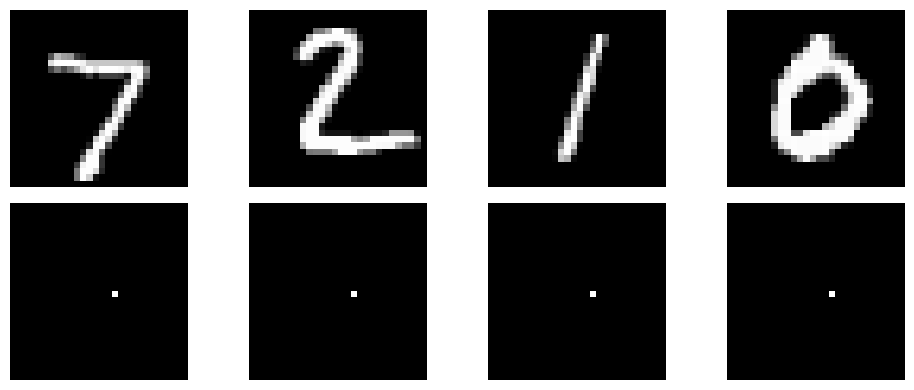

In [9]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(10, 4))

for i in range(4):
    # 元の画像
    axes[0, i].imshow(images[i].view(28, 28).cpu(), cmap='gray')
    axes[0, i].axis('off')
    
    # デコードされた画像
    axes[1, i].imshow(decoded_images[i].view(28, 28).detach().cpu(), cmap='gray')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

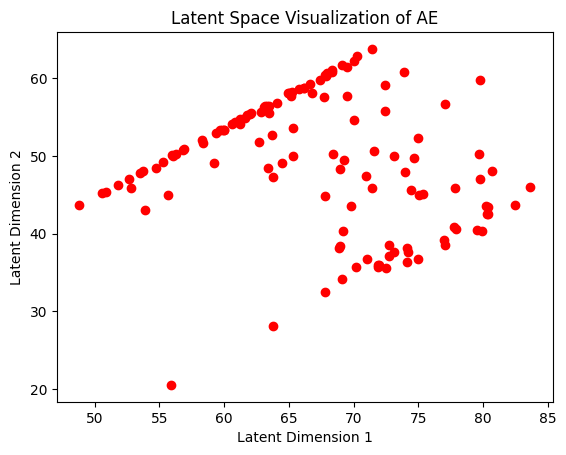

In [10]:
latent_space = encoded_images.cpu().detach().numpy()
# print(latent_space)
# 可視化

fig = plt.figure()
plt.scatter(latent_space[:, 0], latent_space[:, 1], color="r")
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.title('Latent Space Visualization of AE')
fig.savefig("img_ae_z.png")
plt.show()